In [1]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
from h5py import File
from astropy.cosmology import FlatLambdaCDM

import csiborgtools

SPEED_OF_LIGHT = 299792.458  # km / s


%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

## Read in upGLADE

- Mask out galaxies with bad redshifts
- Convert heliocentric redshifts to the CMB frame.

In [2]:
fname = "/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all.h5"
data = {}
with File(fname, "r") as f:
    for i, key in enumerate(["RA", "dec", "zhelio", "e_zhelio"]):
        data[key] = f["data"]["block0_values"][:, i]
data["DEC"] = data.pop("dec")

print(f"Initially, we have {data['zhelio'].size} objects.")

# Ask about this
mask = (data["e_zhelio"] < 0) | (data["zhelio"] < 0)
print(f"Masking {mask.sum()} objects that have `e_zhelio` < 0 or `zhelio` < 0.")
for key in data.keys():
    data[key][mask] = np.nan

mask = (data["e_zhelio"] / data["zhelio"] > 0.1) | (data["e_zhelio"] > 0.1) #& ~np.isnan(data["zhelio"])
print(f"Masking {mask.sum()} objects that have `e_zhelio` / `zhelio` > 0.1.")
for key in data.keys():
    data[key][mask] = np.nan

print(f"Finally, we have {np.sum(np.isfinite(data['zhelio']))} objects.")

Initially, we have 3313157 objects.
Masking 1174652 objects that have `e_zhelio` < 0 or `zhelio` < 0.
Masking 1714681 objects that have `e_zhelio` / `zhelio` > 0.1.
Finally, we have 423824 objects.


/tmp/ipykernel_2891959/606063485.py:16: RuntimeWarning: divide by zero encountered in divide
  mask = (data["e_zhelio"] / data["zhelio"] > 0.1) | (data["e_zhelio"] > 0.1) #& ~np.isnan(data["zhelio"])


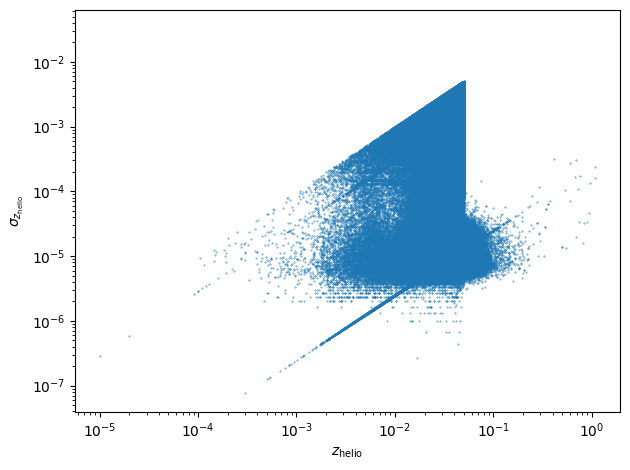

In [3]:
plt.figure()
plt.scatter(data["zhelio"], data["e_zhelio"], s=0.1)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$z_{\rm helio}$")
plt.ylabel(r"$\sigma_{z_{\rm helio}}$")

plt.tight_layout()
plt.show()

In [4]:
zcmb, e_zcmb = csiborgtools.heliocentric_to_cmb(data["zhelio"], data["RA"], data["DEC"], data["e_zhelio"])
data["zcmb"] = zcmb
data["e_zcmb"] = e_zcmb


mask = (data["zcmb"] > 0.06) #& ~np.isnan(data["zhelio"])
print(f"Masking {mask.sum()} objects that have `zcmb` > 0.06.")
for key in data.keys():
    data[key][mask] = np.nan

print(f"Finally, we have {np.sum(np.isfinite(data['zhelio']))} objects.")

Masking 10510 objects that have `zcmb` > 0.06.
Finally, we have 413314 objects.


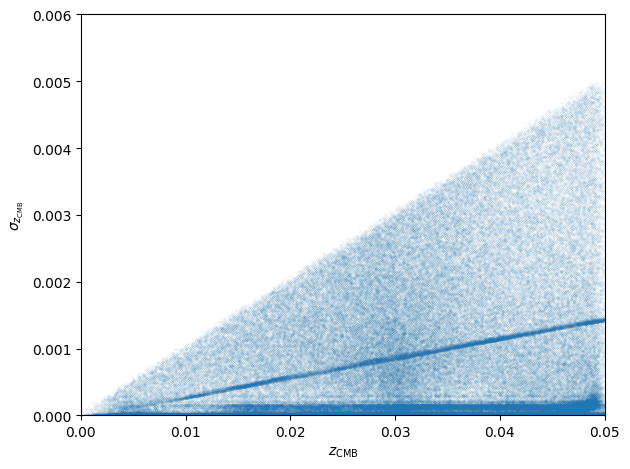

In [56]:
plt.figure()

plt.scatter(data["zcmb"], data["e_zcmb"], s=0.001)
plt.xlabel(r"$z_{\rm CMB}$")
plt.ylabel(r"$\sigma_{z_{\rm CMB}}$")

plt.xlim(0, 0.05)
plt.ylim(0, 0.006)

plt.tight_layout()
plt.savefig("../../plots/UPGLADE_zcmb_vs_ezcmb.png")
plt.show()

- Write only masked galaxies to this file, but also save the mask.

In [6]:
fname = "/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all_PROCESSED.h5"
mask = np.isfinite(data["RA"])
print(f"Writing {mask.sum()} objects to `{fname}`.")

with File(fname, "w") as f:
    for key in data.keys():
        f[key] = data[key][mask]

    f["mask"] = mask

Writing 413314 objects to `/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all_PROCESSED.h5`.


- Having generated this file, next step is to run `field_los.py` to evaluate the density and velocity field along the LOS of each object that is not masked.
- Then, the next step is to run `post_upglade.py` to calculate the cosmological redshift of each object in UPGLADE.
    - Based on Carrick2015 samples calibrated against Pantheon+

### Results verification

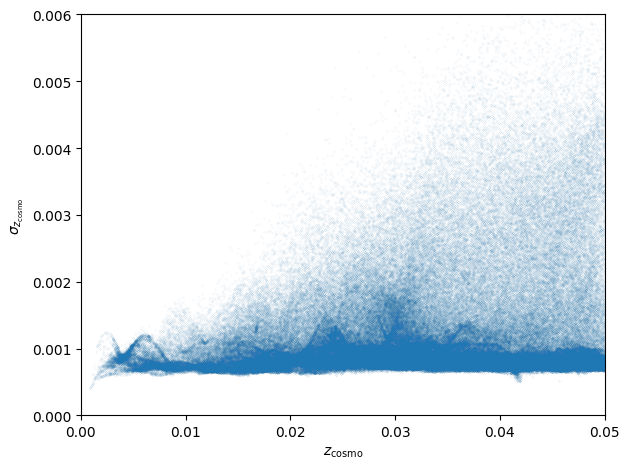

In [57]:
fname = "/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/UPGLADE/zcosmo_UPGLADE.hdf5"

with File(fname, "r") as f:
    indxs = f["indxs"][:]
    mean_zcosmo = f["mean_zcosmo"][:]
    std_zcosmo = f["std_zcosmo"][:]


plt.figure()
plt.scatter(mean_zcosmo, std_zcosmo, s=0.001)

plt.xlabel(r"$z_{\rm cosmo}$")
plt.ylabel(r"$\sigma_{z_{\rm cosmo}}$")

plt.xlim(0, 0.05)
plt.ylim(0, 0.006)
plt.tight_layout()
plt.savefig("../../plots/UPGLADE_zcosmo_vs_ezcosmo.png")


plt.show()

#### Combine datasets
i.e. match to the original UPGLADE file

In [58]:
data["zcosmo"] = np.zeros_like(data["RA"])
data["zcosmo"][mask] = mean_zcosmo

data["e_zcosmo"] = np.zeros_like(data["RA"])
data["e_zcosmo"][mask] = std_zcosmo

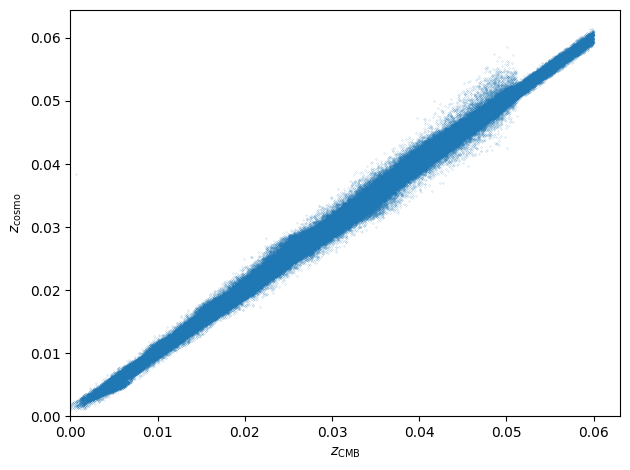

In [59]:
plt.figure()
plt.scatter(data["zcmb"], data["zcosmo"], s=0.01)

plt.xlabel(r"$z_{\rm CMB}$")
plt.ylabel(r"$z_{\rm cosmo}$")
plt.xlim(0)
plt.ylim(0)

plt.tight_layout()
plt.savefig("../../plots/UPGLADE_zcmb_vs_zcosmo.png")

plt.show()

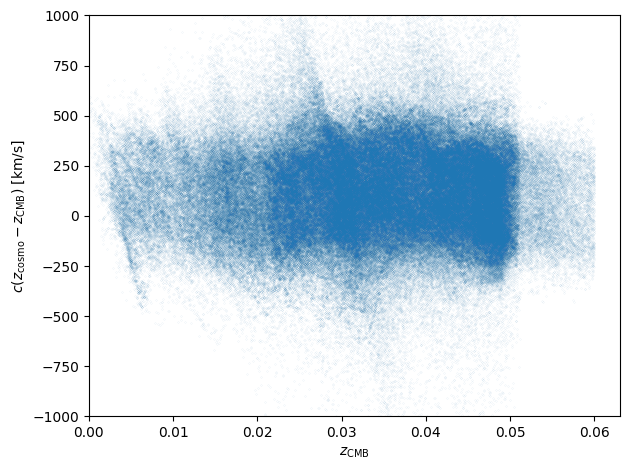

In [60]:
plt.figure()
plt.scatter(data["zcmb"], (data["zcosmo"] - data["zcmb"]) * SPEED_OF_LIGHT, s=0.001)

plt.xlabel(r"$z_{\rm CMB}$")
plt.ylabel(r"$c (z_{\rm cosmo} - z_{\rm CMB}) ~ [\mathrm{km} / \mathrm{s}]$")
plt.xlim(0)
plt.ylim(-1000, 1000)

plt.tight_layout()
plt.savefig("../../plots/UPGLADE_zcmb_vs_dzcosmo.png")
plt.show()

#### Save the data
- In a format matching what Gergely shared.

In [61]:
data

{'RA': array([0.78773861, 0.62294948, 0.02316041, ...,        nan,        nan,
               nan]),
 'zhelio': array([0.02934783, 0.03313865, 0.03167664, ...,        nan,        nan,
               nan]),
 'e_zhelio': array([9.929941e-06, 6.920645e-06, 7.919160e-06, ...,          nan,
                 nan,          nan]),
 'DEC': array([-0.75227238, -0.75948143, -1.21628749, ...,         nan,
                nan,         nan]),
 'zcmb': array([0.02812447, 0.03191   , 0.0304483 , ...,        nan,        nan,
               nan]),
 'e_zcmb': array([9.91813946e-06, 6.91241472e-06, 7.90973125e-06, ...,
                   nan,            nan,            nan]),
 'zcosmo': array([0.02811476, 0.03163086, 0.03017893, ..., 0.        , 0.        ,
        0.        ]),
 'e_zcosmo': array([0.00078133, 0.0006812 , 0.00069302, ..., 0.        , 0.        ,
        0.        ])}

In [62]:
fname = "/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all_WZCOSMO.h5"
print(f"Writing to `{fname}`.")

with File(fname, "w") as f:
    for key in data.keys():
        f[key] = data[key]

Writing to `/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all_WZCOSMO.h5`.


In [63]:
!du -h /mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all_WZCOSMO.h5

40M	/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all_WZCOSMO.h5


/usr/local/shared/python/3.11.7/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
